In [1]:
##############################
#Part 1: LCC Change Detection#
#Maintainer: Christopher Chan#
#Version: 0.0.1              #
##############################

import os

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from pathlib import Path
from PIL import Image
from osgeo import gdal
from rasterio.mask import mask

%matplotlib inline

# path setup
BASE_PATH = Path(os.getcwd())
data_raw = (BASE_PATH/'../data/01_raw').resolve()
data_intermediate = (BASE_PATH/'../data/02_intermediate').resolve()

In [2]:
# First let's explore and visualise the raster and vector data, look for any issues

lc_2020 = gdal.Open(f'{data_raw}/raster/spain_2020.tif')
lc_2020_meta = lc_2020.GetGeoTransform()
print(gdal.Info(lc_2020))

lc_2021 = gdal.Open(f'{data_raw}/raster/spain_2021.tif')
lc_2021_meta = lc_2021.GetGeoTransform()
print(gdal.Info(lc_2021))

lc_2022 = gdal.Open(f'{data_raw}/raster/spain_2022.tif')
lc_2022_meta = lc_2022.GetGeoTransform()
print(gdal.Info(lc_2022))

assert lc_2022.GetProjection() == lc_2021.GetProjection() == lc_2020.GetProjection()

Driver: GTiff/GeoTIFF
Files: /Users/christopherchan/Proj/natcap-interview/data/01_raw/raster/spain_2020.tif
Size is 113214, 181269
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
          

/Users/christopherchan/Proj/natcap-interview/.venv/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


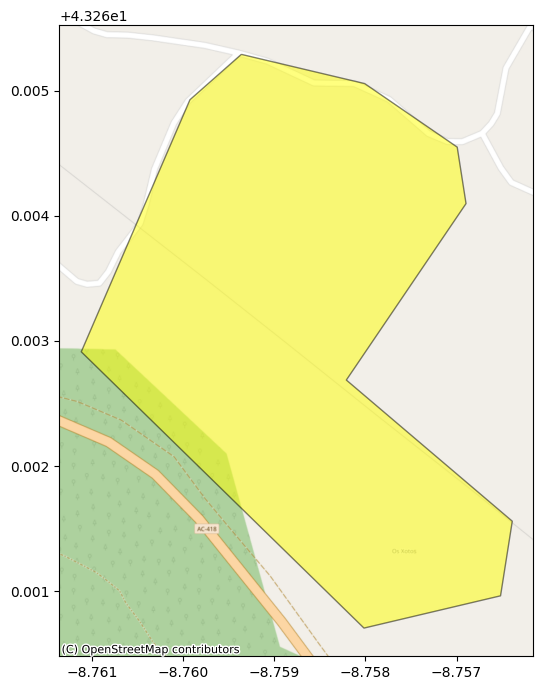

In [3]:
# Clip to AOI
with open(f'{data_raw}/vector/Part_1/id_1.geojson', 'r') as gdf:
    aoi = gpd.read_file(gdf)

fig, ax = plt.subplots(figsize=(7, 7))
ax = aoi.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.5)
cx.add_basemap(ax=ax, crs=aoi.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()
plt.show()

if aoi.crs != 'EPSG:32630':
    aoi_32630 = aoi.to_crs(epsg=32630)
    aoi_32630.to_file(f'{data_raw}/vector/Part_1/id_1_32630.geojson', driver='GeoJSON')


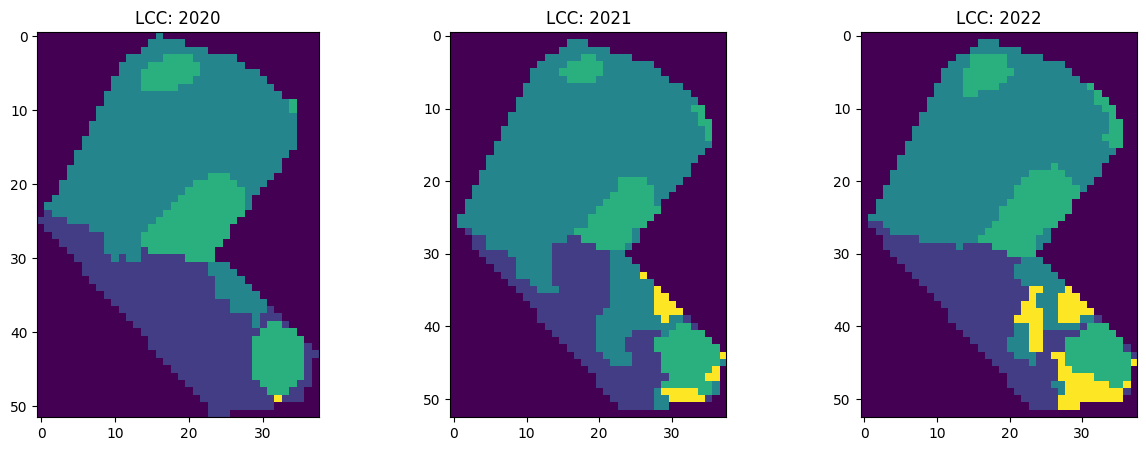

In [4]:
# Clip raster using GDAL_Warp
raster_ls = [lc_2020.GetDescription(), lc_2021.GetDescription(), lc_2022.GetDescription()]

clip_rasterls = []

for raster in raster_ls:
    year = raster.split('_')[2].split('.')[0]

    with rio.open(raster, "r") as src:
        # Note: wrap geometry in a list if it's a single feature
        clipped_image, clipped_transform = mask(src, aoi_32630.geometry, crop=True)

        profile = src.profile.copy()
        profile.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })

    with rio.open(f'{data_intermediate}/raster/Part_1/spain_{year}_clipped.tif', "w", **profile) as dst:
        dst.write(clipped_image)

    # Append the clipped array (which has shape: [bands, height, width])
    clip_rasterls.append(clipped_image)

# Quick plot

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, img in enumerate(clip_rasterls):
    ax[idx].imshow(img[0])
    ax[idx].set_title(f'LCC: {raster_ls[idx].split("_")[2].split(".")[0]}')

In [5]:
# Change Detection
